# Genetic Algorithms

I like to think about our own evolution from a machine learning perspective. Nature is constantly trying to find adaptive fits to our environment. How do we know what's right? Well from one perpsective, evolution takes a very different approach than deep learning. We don't have a "right answer" to create a loss against and then follow some gradient / update our params to minimize loss. Instead what evolution does is it searches the space by firing off a set of answers each iteration and then culling the less successful answers. Basically, each new being is a step across the gradient space. And what's interesting of course is that the gradient space is dynamic! The environment for which our fitness is being tested is constantly changing--it's not searching over a fixed gradient. 

But anyways, I like genetic algorithms because they apply the way evolution uses us to crawl the gradient to actual ML problems. Basically we start with a bunch of randomly seeded answers, and then each iteration (for us, generation) we cull the less successful answers, combine the more successful ones to create similar offspring, and add mutations (aka random noise / drift). This lets us take a step along the space every generation. 

Very cool, and we can replicate it so long as we have our way of assessing the fitness of a given solution, as well as some kind of codification for it such that we can combine codes for two solutions to create a child solution, and we can also introduce mutation in the solution by perturbing the codes. 

Let's start with a simple enough problem just to see how this kind of optimization works! I'll start by creating a random polynomial with k parameters. I just want to see if I can then actually use a genetic algorithm and a fitness function (here the fitness function knows the true polynomial we're aiming for--let's just take MSE) to hone in on the answer. Since each potential solution is parameterized by a set of parameters we can easily remix them across two parents just by randomly choosing, for each param, if it comes from one parent or the other. And we can perturb the children's values each time by a random amount. 

Steps:

1. assess candidates' fitness
2. cull weak candidates
3. breed remaining candidates

You could also consider mutation to be a separate step but we can include it in breeding. 

Let's get started!

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [213]:
class PolyGene:

    def __init__(self, poly_order = 3, param_var = 2, support=1000, num_candidates= 200, init_num_generations=100):

        np.random.seed(12)
        self.order = poly_order
        self.param_var = param_var
        self.x = np.arange(support)
        self.num_candidates = num_candidates
        self.init_num_generations = init_num_generations
        
        self.params_memory = []
        self.fitness_memory = []

        self.gen_true_poly()
        self.initialize_candidates()

        self.run_k_generations(k=self.init_num_generations)
        
    def gen_true_poly(self):
        self.true_params = np.random.normal(0, self.param_var, self.order)
        self.true_poly = np.polyval(self.true_params, self.x)
        
    def initialize_candidates(self):
        self.candidate_params = np.random.normal(0, self.param_var, (self.num_candidates,self.order))
        self.gen_candidate_polynomials()

    def run_k_generations(self, k):
        for i in range(k):
            self.gen_candidate_polynomials()
            self.assess_candidate_fitness()
            self.cull_candidates()
            self.breed_candidates()
            self.mutate_candidates()
        
    def gen_candidate_polynomials(self):
        num_candidates = self.candidate_params.shape[0] # could change per iteration depending on algo
        candidate_poly = []
        for i in range(num_candidates):
            params = self.candidate_params[i]
            poly = np.polyval(params, self.x)
            candidate_poly.append(poly)
        self.candidate_poly = np.array(candidate_poly)
        
    def assess_candidate_fitness(self):
        num_candidates = self.candidate_poly.shape[0]
        fitness = []
        for i in range(num_candidates):
            mse = np.mean((self.candidate_poly[i] - self.true_poly)**2)
            fitness.append(mse)
        self.candidate_fitness = np.array(fitness)

    def cull_candidates(self, cull_ratio = 0.5):
        """
        realistic ways of culling would actually be by magnitude of the fitness function; but let's just cull the bottom k%
        """
        num_candidates = self.candidate_params.shape[0]

        # keep track of history
        self.fitness_memory.append(self.candidate_fitness) 
        self.params_memory.append(self.candidate_params)
        # build and sort df
        self.candidate_df = pd.DataFrame(zip(self.candidate_params, self.candidate_fitness), columns=['params','fitness']).sort_values('fitness')

        # keep only top k%
        num_surviving_candidates = int((1-cull_ratio)*num_candidates)
        self.candidate_df = self.candidate_df.iloc[0:num_surviving_candidates]

        # update candidate_params and candidate_fitness
        self.candidate_params = np.stack(self.candidate_df['params'].to_numpy())
        self.candidate_fitness = np.stack(self.candidate_df['fitness'].to_numpy())

    
    def breed_candidates(self, breed_ratio = 2):
        """
        breed_ratio: number of new candidates per old candidates post-culling
        we'll do pairwise random breeding where we select two random pairs, breed them, and generate an offspring
        """
        num_candidates = self.candidate_params.shape[0]
        child_params_list = []
        num_children = int(num_candidates*breed_ratio)
        for i in range(num_children):
            # pick two parents
            parents_idx = np.random.choice(num_candidates, 2, replace=False)
            # get parent params
            parents_params = self.candidate_params[parents_idx]
            # recombine_idx: a set of 1s and 0s signifying for each param whether the child gets parent 1 or parent 0's param
            # for now we just do each one independently having 50% chance inheritance from either parent
            # for more interesting stuff we could make this non-independent...and could make that a meta-feature of evolution
            # e.g. we could let some params control to what degree a reproduction using correlation at various points
            # DNA kinda works like this I think with epigenetic factors controlling gene expression 
            recombine_idx = np.random.binomial(1, 0.5, self.order)
            child_params = parents_params[0]*recombine_idx + parents_params[1]*(1-recombine_idx) # 1-recombine_idx flips the 1s and 0s!
            child_params_list.append(child_params)
            
        self.candidate_params = np.array(child_params_list)

    def mutate_candidates(self):
        """
        we'll write a fairly contrived mutation / genetic perturbation function
        we'll allow a drift of between -0.01 and 0.01 using draws from a beta distribution
        """
        self.mutations = 0.001*(np.random.beta(100,100, self.candidate_params.shape)-0.5)
        self.candidate_params = self.candidate_params + self.mutations


In [214]:
pg = PolyGene()


In [215]:
np.array(pg.fitness_memory).mean(axis=1) # gives us the evolution of the average population fitness

array([8.70327376e+11, 1.11519923e+11, 3.09444622e+10, 1.07809852e+10,
       7.89795608e+08, 1.93398776e+08, 9.54326586e+07, 2.84187572e+07,
       5.80909541e+06, 2.76932529e+06, 1.64074631e+06, 7.30805283e+05,
       3.18757653e+05, 3.15604834e+05, 3.14033011e+05, 3.12955725e+05,
       3.12173069e+05, 3.11851016e+05, 3.11743787e+05, 3.11665776e+05,
       3.11554304e+05, 3.11600922e+05, 3.11487949e+05, 3.11494105e+05,
       3.11437046e+05, 3.11417411e+05, 3.11393665e+05, 3.11411125e+05,
       3.11431293e+05, 3.11434002e+05, 3.11441557e+05, 3.11396521e+05,
       3.11410269e+05, 3.11438110e+05, 3.11429677e+05, 3.11354191e+05,
       3.11445876e+05, 3.11414603e+05, 3.11468143e+05, 3.11384571e+05,
       3.11367027e+05, 3.11370120e+05, 3.11382622e+05, 3.11340745e+05,
       3.11339623e+05, 3.11364258e+05, 3.11354128e+05, 3.11433435e+05,
       3.11386169e+05, 3.11342976e+05, 3.11352323e+05, 3.11388002e+05,
       3.11340885e+05, 3.11338188e+05, 3.11317155e+05, 3.11355947e+05,
      

In [216]:
np.array(pg.fitness_memory).min(axis=1) # gives us the evolution of the highest fitness individual (min MSE)

array([36548964.85832966, 18155105.98777078,  2937868.12418246,
        2938137.87177085,   318874.87945599,   319179.50410146,
         317897.45455636,   316190.67452139,   313556.03034834,
         314580.54623938,   311764.09007876,   312527.01596599,
         311810.85412737,   311377.35050273,   311220.04330735,
         311140.73855928,   311132.82754708,   311173.99047707,
         311118.71764628,   311140.2932873 ,   311115.51135075,
         311106.51017646,   311109.84623909,   311087.61523001,
         311088.2448773 ,   311100.42334212,   311054.89046582,
         311105.98552235,   311090.38842693,   311061.10820584,
         311049.83600259,   311051.92308937,   311045.58565749,
         311041.78744882,   311030.71419227,   311045.93113962,
         311053.04234489,   311038.05821538,   311039.13866223,
         311038.53425728,   311037.24276623,   311040.8964318 ,
         311023.28310144,   311017.24412199,   311030.49874513,
         311032.15351643,   311025.74364

Nice. It works! We are seeing improvement though it slows down a bit. Only 100 generations is not that much perhaps. The situation will look clearer if we drop our polynomial by an order and the plot the 2 params!

In [217]:
pg = PolyGene(poly_order = 2)


In [218]:
np.array(pg.fitness_memory).mean(axis=1)

array([1.76765067e+06, 2.94638949e+05, 7.59171050e+04, 2.25757471e+04,
       5.17655441e+03, 7.13781243e+02, 2.97366539e+02, 2.28288509e+01,
       7.16272028e+00, 4.14085926e+00, 2.79050687e+00, 2.42190042e+00,
       2.31533049e+00, 2.24322010e+00, 2.18323282e+00, 2.12520732e+00,
       2.07291806e+00, 2.03142428e+00, 1.98355424e+00, 1.94029292e+00,
       1.88766928e+00, 1.84462111e+00, 1.80326562e+00, 1.76024353e+00,
       1.71659938e+00, 1.68387967e+00, 1.64934676e+00, 1.61539385e+00,
       1.58145180e+00, 1.54241525e+00, 1.50640562e+00, 1.47142218e+00,
       1.43578249e+00, 1.40059055e+00, 1.36646425e+00, 1.33991879e+00,
       1.31252815e+00, 1.28393264e+00, 1.26066369e+00, 1.24097594e+00,
       1.22152003e+00, 1.20443124e+00, 1.18433465e+00, 1.16160643e+00,
       1.14050334e+00, 1.12056913e+00, 1.09695353e+00, 1.07816134e+00,
       1.06120803e+00, 1.04730390e+00, 1.03360289e+00, 1.02104225e+00,
       1.01243331e+00, 1.00371011e+00, 9.95062290e-01, 9.86998594e-01,
      

In [219]:
np.array(pg.fitness_memory).min(axis=1)

array([86.16604704, 86.30109894,  3.31478038,  3.30586888,  2.32778264,
        2.28965632,  2.25963477,  2.2761696 ,  2.25363769,  2.1922744 ,
        2.10962752,  2.04674163,  2.04736867,  1.99264478,  1.98034979,
        1.9377864 ,  1.92813217,  1.85133458,  1.79866184,  1.74951278,
        1.70103388,  1.68972226,  1.6628953 ,  1.61005277,  1.56746616,
        1.55328138,  1.49512941,  1.47271169,  1.41678381,  1.37361698,
        1.37795284,  1.32688439,  1.33496511,  1.29412432,  1.28381882,
        1.25671409,  1.23613318,  1.1955967 ,  1.16799278,  1.12960371,
        1.13794037,  1.12237923,  1.09938295,  1.06837357,  1.04220937,
        1.03690581,  1.01559902,  1.01922203,  1.01507896,  1.00289593,
        0.994182  ,  0.9928187 ,  0.97967169,  0.97274366,  0.96558574,
        0.96262507,  0.95862034,  0.95749121,  0.95596143,  0.95603444,
        0.9559861 ,  0.95580784,  0.95594302,  0.95579852,  0.95574634,
        0.955705  ,  0.95567723,  0.95571465,  0.95563517,  0.95

OK! In 2D we can see that our algorithm does actually converge really quick...but with no cut off point it then starts to drift away eventually!

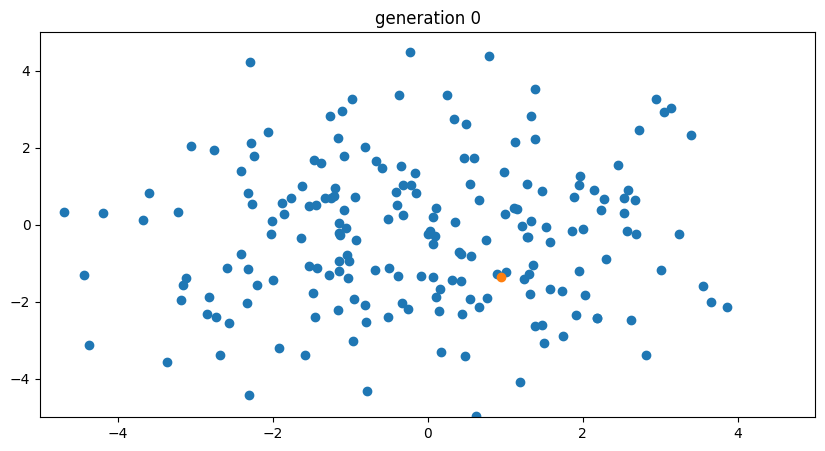

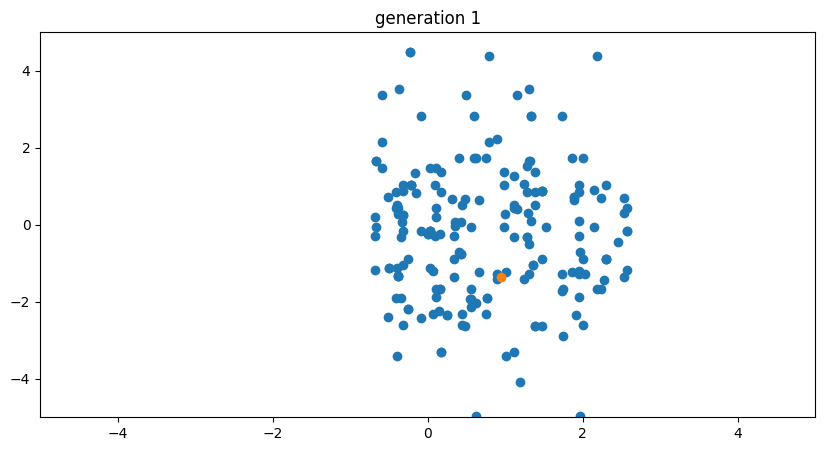

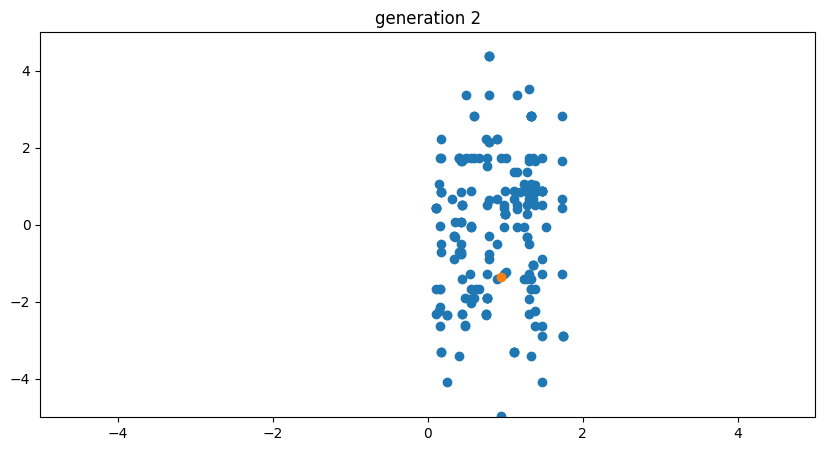

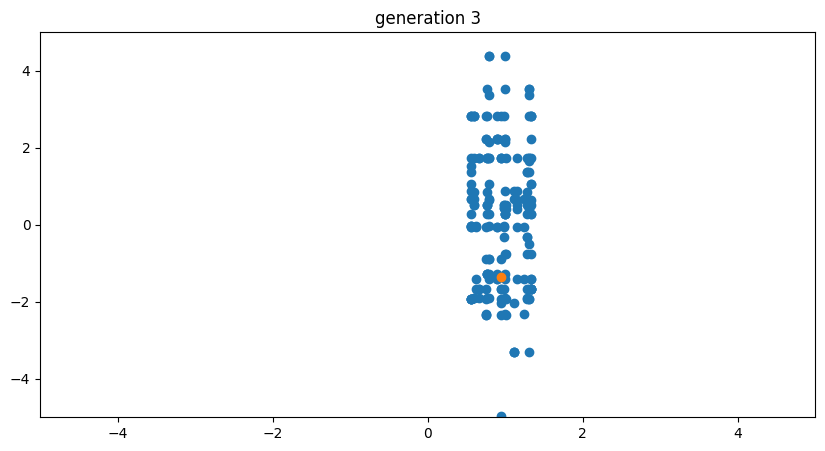

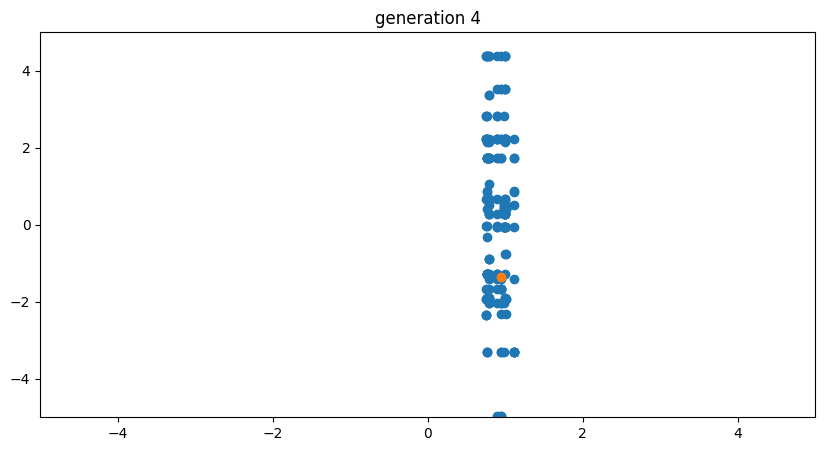

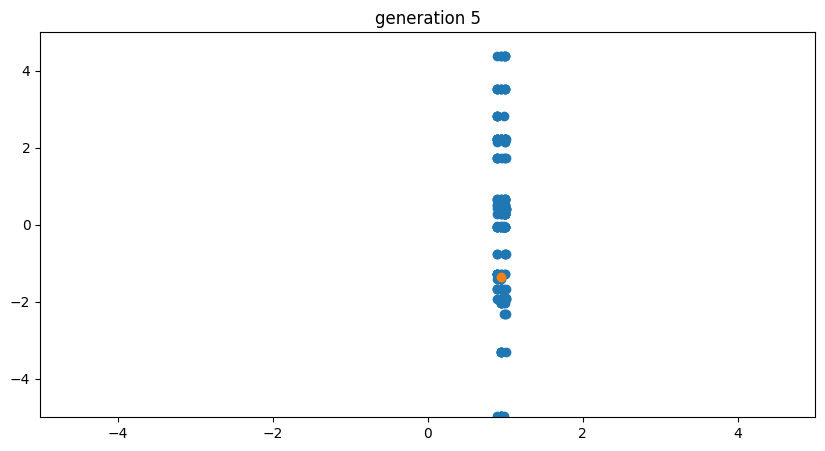

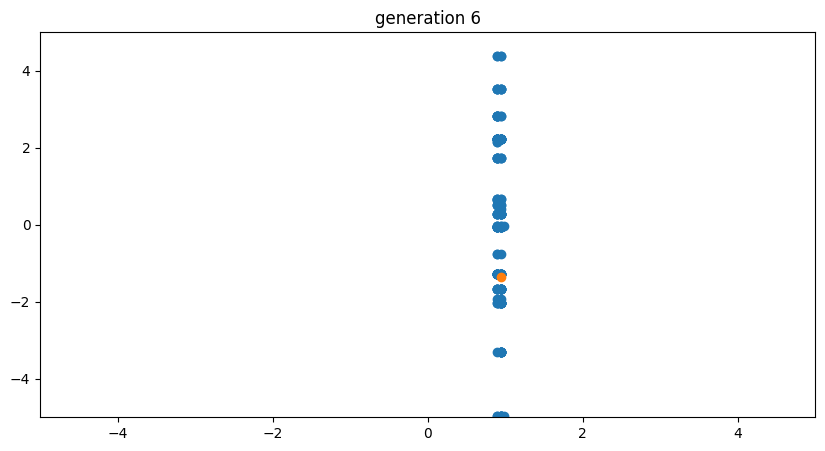

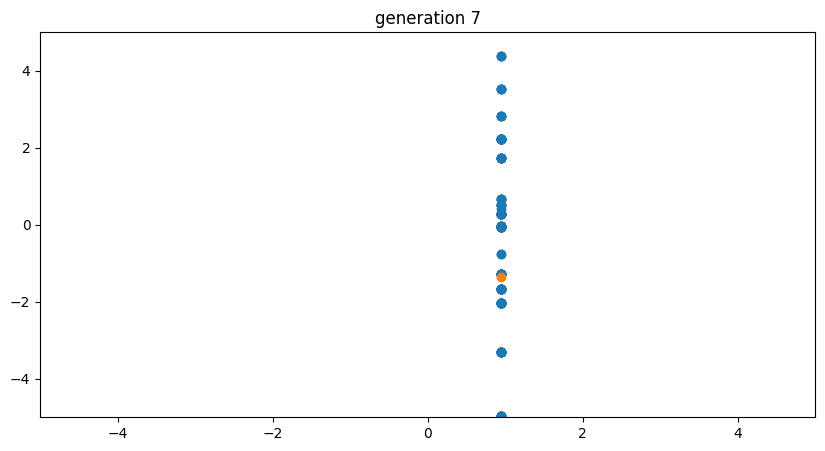

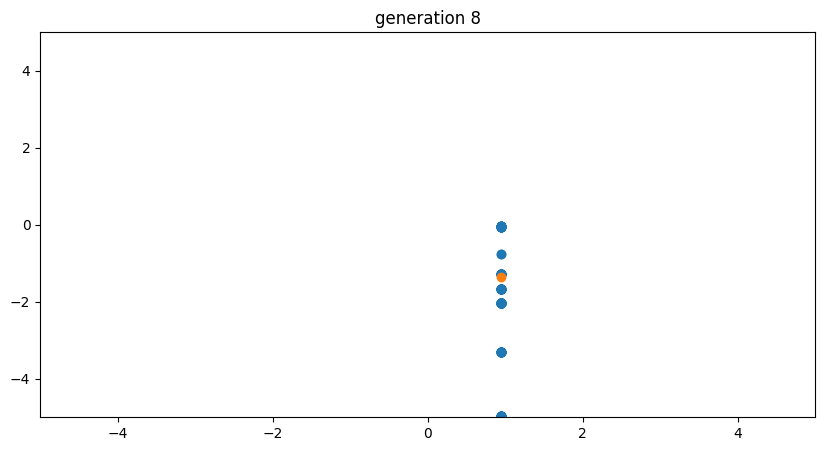

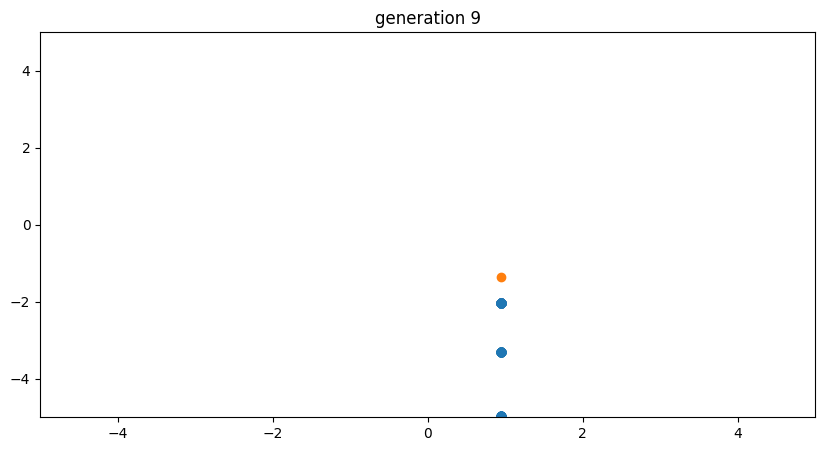

In [222]:
for i in range(0,10):
    
    plt.figure(figsize=(10,5))
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.scatter(pg.params_memory[i][:,0], pg.params_memory[i][:,1])
    plt.scatter(pg.true_params[0], pg.true_params[1])
    plt.title('generation ' + str(i))

So we see how our strategy converges in parameter space! Even though the MSE converges to a low value (both in mean mse and min mse per generation) we see that behavior in parameter space is a little weird--our last gen is actually worse than our second to last. But this actually makes sense--we are assessing on distance in MSE over y, not directly on distance in our parameters, and the map between the two is intrinsically a bit weird. For example one of our parameters matters more than the other, so we get real close in one param but still see a lot of spread in the other. In other words our slope term matters way more than our intercept term does! Which makes sense!

Overall, pretty nice first shot and demonstration of what a genetic algorithm looks like!